In [1]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision import datasets
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import List, Tuple, Dict 
import random
from pathlib import Path
from torch.utils.data import DataLoader
from PIL import Image



from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision import transforms

from torchvision.transforms.v2 import SanitizeBoundingBox as SBox


print(f'PyTorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

# https://medium.com/@anumolcs1996/image-gradient-for-edge-detection-in-pytorch-a9498a7827d6

PyTorch version: 2.0.1
torchvision version: 0.15.2


C:\Users\Valentine\anaconda3\envs\pytorch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\Valentine\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [2]:
img_class_name = {0:'clean', 1:'dirty'}
img_class_name_inverse = {'clean':0, 'dirty':1}

In [3]:
img_partition = {0:'train', 1:'test', 2:'hidden'}
img_partition_inverse = {'train':0, 'test':1, 'hidden':2}

In [4]:
class CudaHelper:
    
    def get_device():
        device = "cuda" if torch.cuda.is_available() else "cpu"
        return device

In [5]:
class ImageItem:
    
    def __init__(self, image:torch.Tensor, full_path:str, image_class:int, image_partition:int):
        self.image = image
        self.full_path = full_path
        self.image_class = image_class
        self.image_partition = image_partition
    
    def stringify(self):
        return f'Class: {img_class_name[self.image_class]}:{self.image_class}. Partition: {img_partition[self.image_partition]}'

In [6]:
class ImageHelper:
    
    def plot_tensor(img:torch.Tensor):
        img_cpu = img.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.show()
    
    def plot_img(img:ImageItem):
        img_cpu = img.image.squeeze().to('cpu')
        plt.imshow(img_cpu.permute(1, 2, 0))
        plt.title(f'{img.stringify()}')
        plt.show()
    
    def do_load(data_dir:str, partition:str, class_name:str) -> List[ImageItem]:
        all_files = os.listdir(data_dir)
        all_images = []

        for f in all_files:
            full_path = os.path.join(data_dir, f)
            img_tensor = read_image(full_path).to(CudaHelper.get_device())
            ii = ImageItem(img_tensor, full_path, img_class_name_inverse[class_name], img_partition_inverse[partition])
            all_images.append(ii)
        
        return all_images
    
    def load_images(base_dir:str, partition:str) -> List[ImageItem]:        
        cleans = ImageHelper.do_load(os.path.join(base_dir, partition, 'clean'), partition, 'clean')
        dirtys = ImageHelper.do_load(os.path.join(base_dir, partition, 'dirty'), partition, 'dirty')
        return cleans, dirtys
    
    def gradient_transform(img:torch.Tensor):
        img = img.squeeze(0)
        ten=torch.unbind(img)
        x=ten[0].unsqueeze(0).unsqueeze(0)

        a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
        conv1=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv1.weight=nn.Parameter(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0))
        G_x=conv1(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
        conv2=nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1, bias=False)
        conv2.weight=nn.Parameter(torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0))
        G_y=conv2(Variable(x)).data.view(1,x.shape[2],x.shape[3])

        G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
        return G


In [7]:
class ImageTransformer:
    
    def plot_transformed_images(image_items:List[ImageItem], transform, n=3, seed=42):

        random.seed(seed)
        random_image_items = random.sample(image_items, k=n)
        for item in random_image_items:
            with Image.open(item.full_path) as f:

                # original
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(f) 
                ax[0].set_title(f"Original \nSize: {f.size}")
                ax[0].axis("off")

                # transformed
                transformed_image = transform(f).permute(1, 2, 0) 
                ax[1].imshow(transformed_image) 
                ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
                ax[1].axis("off")

                fig.suptitle(f"{item.stringify()}", fontsize=16)

## Print several random images

In [8]:
main_dir = 'C:\\Users\\Valentine\\Downloads\\NeuralNetworks\\plates\\plates\\'

clean_train, dirty_train = ImageHelper.load_images(main_dir, 'train')
clean_test, dirty_test = ImageHelper.load_images(main_dir, 'test')
clean_hidden, dirty_hidden = ImageHelper.load_images(main_dir, 'hidden')

In [9]:
_ALL_ITEMS_ = [*clean_train, *dirty_train, *clean_test, *dirty_test, *clean_hidden, *dirty_hidden]
_ALL_PATHS_ = [i.full_path for i in _ALL_ITEMS_]

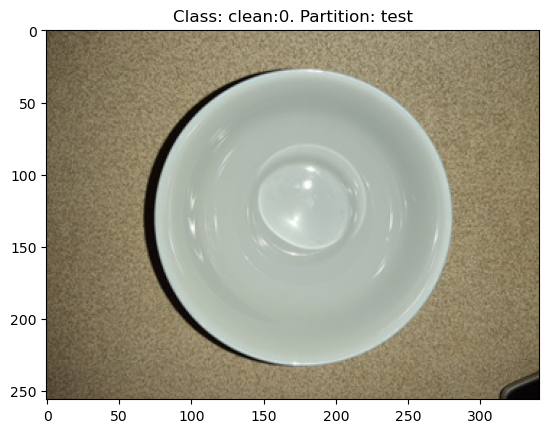

In [10]:
ImageHelper.plot_img(random.choice(_ALL_ITEMS_))

## Do image augmentation 

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
])

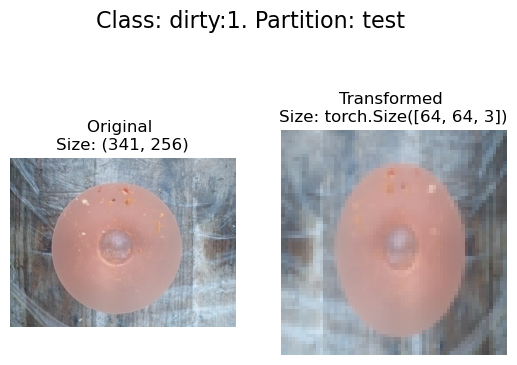

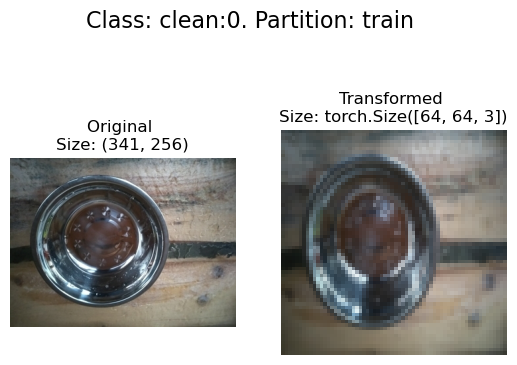

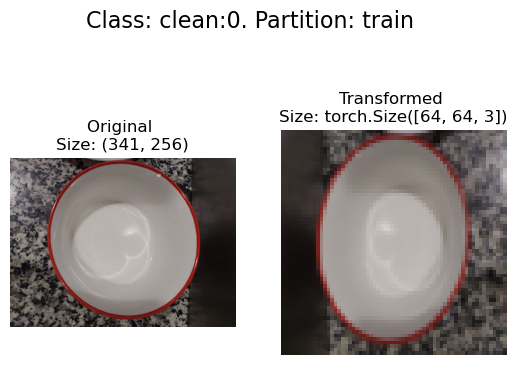

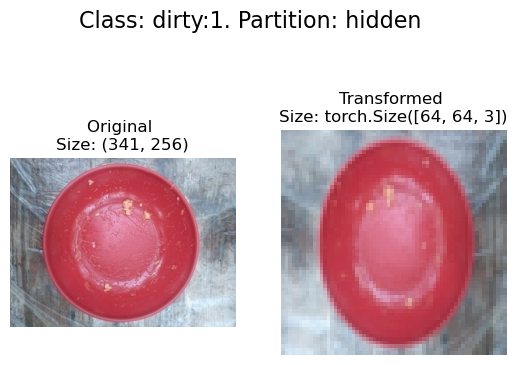

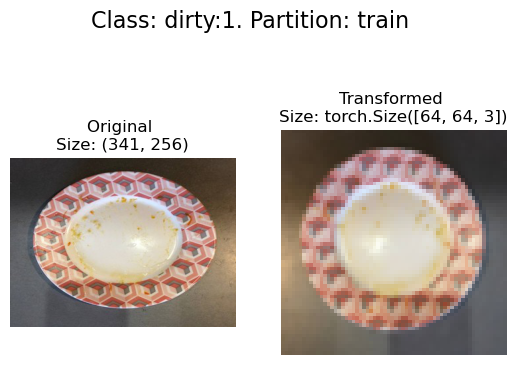

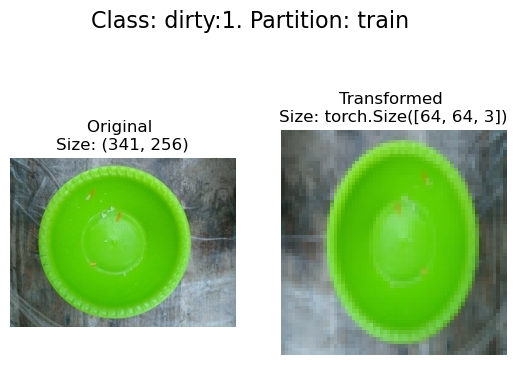

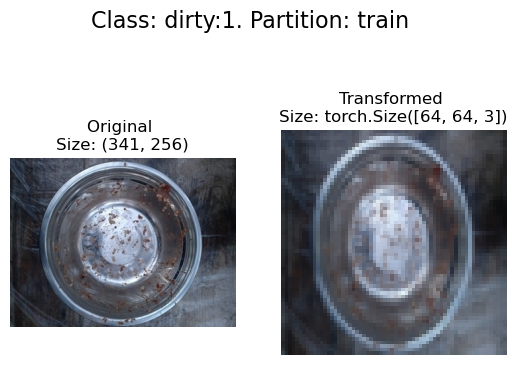

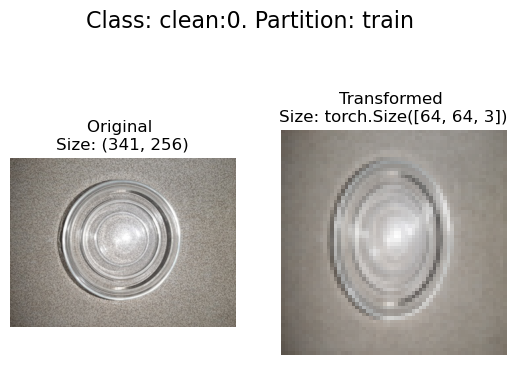

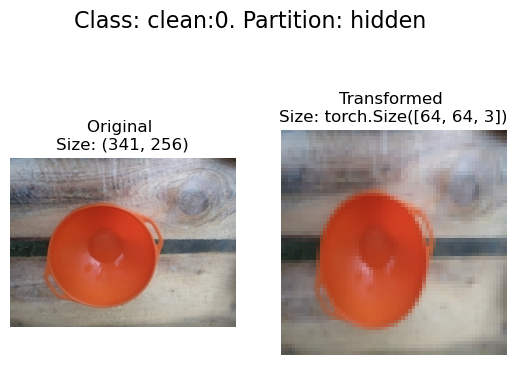

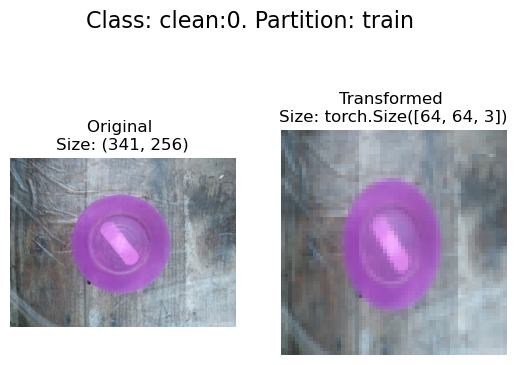

In [12]:
ImageTransformer.plot_transformed_images(_ALL_ITEMS_, transform=data_transform, n=10)

## Create data loader

In [19]:
train_path = Path(clean_train[0].full_path).parent.parent
test_path = Path(clean_test[0].full_path).parent.parent

In [20]:
train_data = datasets.ImageFolder(root=train_path, transform=data_transform)
test_data = datasets.ImageFolder(root=test_path, transform=data_transform) 
print(f'Train data: {train_data}')
print(f'Train data: {test_data}')

Train data: Dataset ImageFolder
    Number of datapoints: 300
    Root location: C:\Users\Valentine\Downloads\NeuralNetworks\plates\plates\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Train data: Dataset ImageFolder
    Number of datapoints: 450
    Root location: C:\Users\Valentine\Downloads\NeuralNetworks\plates\plates\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
